### 分析目標
- 資料內容：
    - 資料來源：東森新聞
    - 版別：財經、政治、國際、體育
- 分析主題：將蘋果日報四個版別的文章合起來，訓練模型能預測新聞版別，再用分類模型進行文件的版別分類。

### 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。

- sklearn: 全名為Scikit-learn，機器學習的常用建模套件，包含各種分群、分類、迴歸模型，如隨機森林、SVM或 K-means 等。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- jieba: 結巴套件，中文斷詞套件
- seaborn: 基於 matplotlib 封裝的繪圖工具

In [2]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

設定中文字體

In [3]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']#使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示


### 2. 文字前處理
ebc_news.csv裡面包含了要分析東森新聞資料。

- 版別：財經、政治、國際、體育
- 時間範圍：2024/03/01 ~ 2024/04/04
- 工作流程平台搜尋/排除關鍵字：無

首先我們先看文集的基本資料，並做文集前處理。

In [6]:
apple = pd.read_csv("raw_data/ebc_news.csv")  # 匯資料
apple.head(3)

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,1,才喊話2年砍2萬人！花旗宣布「裁紐約286名員工」｜東森新聞,https://news.ebc.net.tw/news/article/407802,2024-03-01 13:40:00,財經,美國花旗集團日前才宣布，將在未來2年裁員2萬人，而根據該集團近日向美國勞工部（StateDe...,EBC
1,2,新／中鋼配0.35元 百萬股東哭了｜東森新聞,https://news.ebc.net.tw/news/article/407803,2024-03-01 12:41:00,財經,中鋼（2002）29日公布去年財報，112年度分配特別股股息每股現金1.4元及普通股紅利每股...,EBC
2,3,睡覺都有股票掉下來 達人曝挑個股2要件！｜東森新聞,https://news.ebc.net.tw/news/article/407835,2024-03-01 15:34:00,財經,投資人追求穩定的被動收入，不過，要是沒有足夠的本金，領到的股息也只能祭祭五臟廟；王仲麟認為，...,EBC


In [7]:
# 看看有幾篇文章
print(f"number of posts: {apple.shape[0]}")
print(f"date range: {(apple['artDate'].min(), apple['artDate'].max())}")
print(f"category: \n{apple['artCatagory'].value_counts()}")

number of posts: 1333
date range: ('2024-03-01 06:30:00', '2024-04-04 22:17:00')
category: 
artCatagory
國際    741
政治    302
財經    146
體育    144
Name: count, dtype: int64


### 2.1 斷句、斷詞（刪掉次數太少的、標點符號、停用字）

### 2.1 清理

利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是...也會斷句，最後設定會去除結尾的空白符號。

In [8]:
# 過濾 nan 的資料
apple= apple.dropna(subset=['artTitle'])
apple = apple.dropna(subset=['artContent'])
# 移除網址格式
apple["artContent"] = apple.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
apple["artTitle"] = apple["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
apple["artContent"] = apple.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
apple["artTitle"] = apple["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
apple.head(3)

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,1,才喊話年砍萬人花旗宣布裁紐約名員工東森新聞,https://news.ebc.net.tw/news/article/407802,2024-03-01 13:40:00,財經,美國花旗集團日前才宣布將在未來年裁員萬人而根據該集團近日向美國勞工部提交的文件花旗集團將先在...,EBC
1,2,新中鋼配元百萬股東哭了東森新聞,https://news.ebc.net.tw/news/article/407803,2024-03-01 12:41:00,財經,中鋼日公布去年財報年度分配特別股股息每股現金元及普通股紅利每股現金元而如果以當日收盤元來看現...,EBC
2,3,睡覺都有股票掉下來達人曝挑個股要件東森新聞,https://news.ebc.net.tw/news/article/407835,2024-03-01 15:34:00,財經,投資人追求穩定的被動收入不過要是沒有足夠的本金領到的股息也只能祭祭五臟廟王仲麟認為想加速滾大...,EBC


文章的標題artTitle和內文sentence都會納入分析的內容，成為新的content欄位。

In [9]:
# 留下 content
apple["content"] = apple["artTitle"] + apple["artContent"]
apple = apple[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
apple.head()

,content,artUrl,artCatagory
0,才喊話年砍萬人花旗宣布裁紐約名員工東森新聞美國花旗集團日前才宣布將在未來年裁員萬人而根據該集...,https://news.ebc.net.tw/news/article/407802,財經
1,新中鋼配元百萬股東哭了東森新聞中鋼日公布去年財報年度分配特別股股息每股現金元及普通股紅利每股...,https://news.ebc.net.tw/news/article/407803,財經
2,睡覺都有股票掉下來達人曝挑個股要件東森新聞投資人追求穩定的被動收入不過要是沒有足夠的本金領到...,https://news.ebc.net.tw/news/article/407835,財經
3,房市虛坪改革上膛政院拋兩策略喊公設可降東森新聞內政部最新祭出虛坪改革兩大方案將會從停車空間管...,https://news.ebc.net.tw/news/article/407854,財經
4,萬股東哭哭中鋼配息元三年新低東森新聞被外界號稱是被鋼鐵耽誤的紀念品公司中鋼每年的股東會紀念品...,https://news.ebc.net.tw/news/article/407864,財經


In [10]:
# 看看有幾篇文章
print(f"total docs: {apple.shape[0]}")

total docs: 1333


### 2.2 斷詞

In [11]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [12]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [13]:
apple["words"] = apple["content"].apply(getToken).map(" ".join)
apple.head()

Building prefix dict from /Users/wuanjie/Desktop/NLP/SocialAnalysis_2nd/dict/dict.txt ...


Dumping model to file cache /var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/jieba.u838ae815cfd34ee3f709b81df81421fa.cache
Loading model cost 2.412 seconds.
Prefix dict has been built successfully.


,content,artUrl,artCatagory,words
0,才喊話年砍萬人花旗宣布裁紐約名員工東森新聞美國花旗集團日前才宣布將在未來年裁員萬人而根據該集...,https://news.ebc.net.tw/news/article/407802,財經,喊話 萬人 花旗 宣布 紐約 員工 東森 新聞 美國 花旗 集團 日前 宣布 將在 未來 裁...
1,新中鋼配元百萬股東哭了東森新聞中鋼日公布去年財報年度分配特別股股息每股現金元及普通股紅利每股...,https://news.ebc.net.tw/news/article/407803,財經,中鋼 配元百萬 股東 東森 新聞 中鋼 公布 去年 財報 年度 分配 特別股 股息 每股 現...
2,睡覺都有股票掉下來達人曝挑個股要件東森新聞投資人追求穩定的被動收入不過要是沒有足夠的本金領到...,https://news.ebc.net.tw/news/article/407835,財經,睡覺 股票 掉下來 達人 曝挑 個股 要件 東森 新聞 投資人 追求 穩定 被動 收入 足夠...
3,房市虛坪改革上膛政院拋兩策略喊公設可降東森新聞內政部最新祭出虛坪改革兩大方案將會從停車空間管...,https://news.ebc.net.tw/news/article/407854,財經,房市 虛坪 改革 上膛 政院 拋兩 策略 公設 可降 東森 新聞 內政部 祭出 虛坪 改革 ...
4,萬股東哭哭中鋼配息元三年新低東森新聞被外界號稱是被鋼鐵耽誤的紀念品公司中鋼每年的股東會紀念品...,https://news.ebc.net.tw/news/article/407864,財經,股東 哭哭 中鋼 配息 三年 新低 東森 新聞 外界 號稱 鋼鐵 耽誤 紀念品 公司 中鋼 ...


### 2.3 資料集基本檢視

In [14]:
print(f"total posts: {len(apple['artUrl'].unique())}")
print(f"category: \n{apple['artCatagory'].value_counts()}")

total posts: 1333
category: 
artCatagory
國際    741
政治    302
財經    146
體育    144
Name: count, dtype: int64


### 3. 分類模型的訓練流程
### 3.1 根據7:3的比例切分資料集

利用 sklearn 中的 train_test_split 函數將 raw_data 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。y_train和y_test分別為訓練資料和測試資料的預測目標。

In [15]:
data = apple
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

268     國民黨 推第二波 改革 朱立倫 智庫 年輕 輕量 造化 東森 新聞 青年 想法 引進 智庫 ...
411     綠營 大老 不忍 林光華 北台 全軍覆沒 總統 凝重 東森 新聞 大選 政壇 焦點 鎖定 立...
641     重機 網美 印度 性侵 毆打 驚悚 過程 東森 新聞 印度 日前 發生 震驚 事件 一名 西...
1082    股票 帳戶 突多 夫妻 得知 真相 失望 東森 新聞 投資 股票 致富 承擔 背後 風險 蘇...
672     厄瓜多 動物 海島 天堂 火山 爆發 威脅 獨特 野生 動物 東森 新聞 南美洲 國家 厄瓜...
Name: words, dtype: object
268     政治
411     政治
641     國際
1082    國際
672     國際
Name: artCatagory, dtype: object


In [16]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
artCatagory
國際    55.588897
政治    22.655664
財經    10.952738
體育    10.802701
Name: proportion, dtype: float64

train percentage :
artCatagory
國際    54.662379
政治    23.794212
財經    10.932476
體育    10.610932
Name: proportion, dtype: float64

test percentage :
artCatagory
國際    57.75
政治    20.00
體育    11.25
財經    11.00
Name: proportion, dtype: float64


### 3.2 將文章轉為 DTM

DTM(document term matrix) :

- 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    - row 是document (文件)
    - column 是字詞 (term)
    - row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法
- (1) 依據詞頻 (classic BoW)
    - 用 CountVectorizer()
    - unigrams and bigrams
    - sklearn.feature_extraction.text.CountVectorizer

- (2) 依據tfidf (advanced variant of BoW)
    - 篩選出現次數大於10的字
    - 用 TfidfVectorizer()
    - sklearn.feature_extraction.text.TfidfVectorizer

- 常用參數介紹
    - max_features: 取 詞頻 / tfidf 前多少的字

### 3.3 套入正式的資料集

- 模型訓練範例: logistic regression + cv tokenizer

In [17]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [18]:
X_train.head()

268     國民黨 推第二波 改革 朱立倫 智庫 年輕 輕量 造化 東森 新聞 青年 想法 引進 智庫 ...
411     綠營 大老 不忍 林光華 北台 全軍覆沒 總統 凝重 東森 新聞 大選 政壇 焦點 鎖定 立...
641     重機 網美 印度 性侵 毆打 驚悚 過程 東森 新聞 印度 日前 發生 震驚 事件 一名 西...
1082    股票 帳戶 突多 夫妻 得知 真相 失望 東森 新聞 投資 股票 致富 承擔 背後 風險 蘇...
672     厄瓜多 動物 海島 天堂 火山 爆發 威脅 獨特 野生 動物 東森 新聞 南美洲 國家 厄瓜...
Name: words, dtype: object

In [19]:
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
vec_train

<933x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 44087 stored elements in Compressed Sparse Row format>

In [20]:
### 用 `toarray()` 轉成 numpy array
vec_train.toarray()

array([[0, 0, 0, ..., 0, 4, 2],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [21]:
# 可用 `fit_transform()` 一次完成
vec_train = vectorizer.fit_transform(X_train)
print(vectorizer.get_feature_names_out()[:10])

['一下' '一位' '一名' '一場' '一天' '一平' '一年' '一度' '一張' '一次']


In [22]:
# fit 完後，可以用 `vocabulary_` 看到詞的 feature index
print(vectorizer.vocabulary_)
vectorizer.vocabulary_['一位']

{'國民黨': 226, '改革': 448, '朱立倫': 504, '年輕': 348, '東森': 507, '新聞': 461, '所謂': 398, '組織': 703, '則是': 136, '地方': 235, '國會': 225, '完全': 293, '議題': 831, '主席': 41, '立法院': 687, '黨團': 999, '能夠': 753, '月號': 494, '召開': 177, '推動': 430, '呼籲': 204, '中央': 35, '立委': 685, '參與': 169, '長期': 930, '認為': 816, '進一步': 889, '機構': 523, '黨主席': 998, '積極': 677, '合作': 193, '外界': 256, '全國': 101, '北市': 153, '市長': 340, '工作': 334, '正在': 532, '綠營': 713, '總統': 722, '大選': 267, '焦點': 587, '表現': 785, '藍綠': 774, '選舉': 905, '紛紛': 701, '加強': 144, '民進黨': 549, '共同': 116, '董事長': 768, '台灣': 184, '檢討': 527, '蔡英文': 769, '專業': 313, '部分': 911, '包含': 150, '方面': 465, '希望': 341, '女性': 278, '力量': 141, '繼續': 724, '經營': 709, '負責': 833, '現在': 609, '相關': 659, '關係': 935, '問題': 210, '協助': 159, '解決': 800, '包括': 151, '安排': 292, '立法院長': 688, '韓國': 962, '院長': 941, '相信': 658, '想要': 378, '成為': 389, '近期': 868, '邀請': 908, '助理': 146, '參加': 168, '亞洲': 53, '規劃': 795, '民眾': 547, '印度': 163, '過程': 897, '日前': 470, '發生': 647, '震驚': 957, '事件': 48, '一名': 2, '丈夫':

1

In [23]:
# 不需重新 `fit()` data，因前面已經 `fit()` 過了
# 只需將測試數據使用之前訓練好的 vectorizer 轉換為相同的特徵表示形式，而不需要重新fit。
# 如果對測試數據再次 fit vectorizer，可能會導致使用了測試數據的信息，進而導致模型的不穩定性和過度擬合的問題。
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)

(933, 1000)
(400, 1000)


In [24]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

LogisticRegression()

In [25]:
clf.classes_

array(['國際', '政治', '財經', '體育'], dtype=object)

In [26]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['政治' '政治' '國際' '國際' '國際' '國際' '國際' '體育' '政治' '國際']


In [27]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(400, 4)


array([8.81687654e-07, 9.99995777e-01, 7.61750453e-07, 2.57908402e-06])

In [28]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          國際       0.96      0.97      0.97       231
          政治       0.93      0.94      0.93        80
          財經       0.95      0.89      0.92        44
          體育       1.00      0.96      0.98        45

    accuracy                           0.95       400
   macro avg       0.96      0.94      0.95       400
weighted avg       0.96      0.95      0.95       400



In [29]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[225,   5,   1,   0],
       [  4,  75,   1,   0],
       [  4,   1,  39,   0],
       [  2,   0,   0,  43]])

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, '國際'),
  Text(0, 1.5, '政治'),
  Text(0, 2.5, '財經'),
  Text(0, 3.5, '體育')])

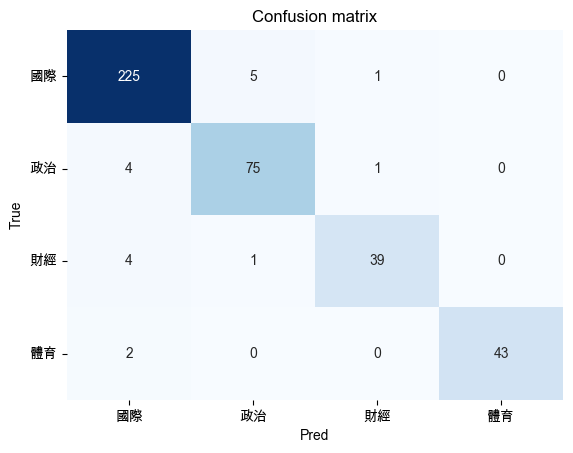

In [30]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

### 3.4 tfidf

改試試看使用 tf-idf 的 DTM 來代表文章，訓練分類模型的效果

In [31]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vec_train.toarray()[0,:]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.08634001, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.09235892, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [32]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          國際       0.89      0.99      0.94       231
          政治       0.96      0.82      0.89        80
          財經       0.94      0.77      0.85        44
          體育       1.00      0.87      0.93        45

    accuracy                           0.92       400
   macro avg       0.95      0.86      0.90       400
weighted avg       0.92      0.92      0.92       400



效果一樣也是不錯，可能因為四個新聞版別本來就有很大的差異，用字會不太一樣～

### 3.5 CV

接著介紹 cross-validation。CV 在機器學習中，是一個很常用來讓模型評估能夠得到更穩定的數值的手法。

cross-validation 會自動切成 k 組 train-test dataset。

cross_validate() 會回傳經過 cross-validation 的模型評估結果。

In [33]:
clf = LogisticRegression()
vec_train = TfidfVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.11377192, 0.08176517, 0.09965682, 0.09862113, 0.09549713]),
 'score_time': array([0.02565002, 0.02205491, 0.02699804, 0.02472591, 0.02369094]),
 'test_f1_macro': array([0.85176788, 0.87672099, 0.83977487, 0.7944256 , 0.92129356]),
 'test_precision_macro': array([0.91559829, 0.94731638, 0.94380356, 0.92756391, 0.97173913]),
 'test_recall_macro': array([0.81070261, 0.82825077, 0.77862554, 0.73277629, 0.88522727])}


cross_val_predict() 則會回傳 cv 預測的類別。

In [34]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          國際       0.84      0.99      0.91       510
          政治       0.97      0.83      0.90       222
          財經       0.97      0.62      0.75       102
          體育       0.97      0.79      0.87        99

    accuracy                           0.89       933
   macro avg       0.94      0.81      0.86       933
weighted avg       0.90      0.89      0.89       933



### 4. 比較不同模型效果

In [36]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

              precision    recall  f1-score   support

          國際       0.84      0.99      0.91       510
          政治       0.97      0.83      0.90       222
          財經       0.97      0.62      0.75       102
          體育       0.97      0.79      0.87        99

    accuracy                           0.89       933
   macro avg       0.94      0.81      0.86       933
weighted avg       0.90      0.89      0.89       933



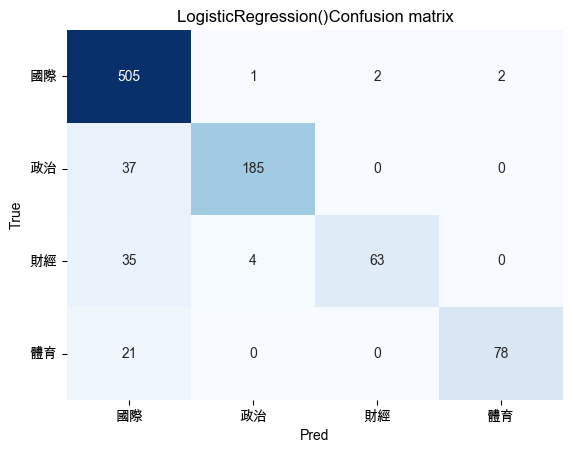

In [37]:
vectorizer = TfidfVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

now training: clf_logistic
              precision    recall  f1-score   support

          國際       0.84      0.99      0.91       510
          政治       0.97      0.83      0.90       222
          財經       0.97      0.62      0.75       102
          體育       0.97      0.79      0.87        99

    accuracy                           0.89       933
   macro avg       0.94      0.81      0.86       933
weighted avg       0.90      0.89      0.89       933

now training: clf_dtree
              precision    recall  f1-score   support

          國際       0.83      0.89      0.86       510
          政治       0.85      0.78      0.82       222
          財經       0.66      0.62      0.64       102
          體育       0.91      0.84      0.87        99

    accuracy                           0.83       933
   macro avg       0.81      0.78      0.80       933
weighted avg       0.83      0.83      0.83       933

now training: clf_svm
              precision    recall  f1-score   support

  

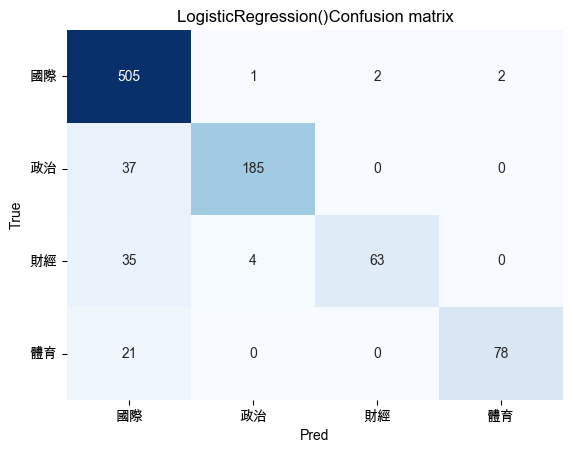

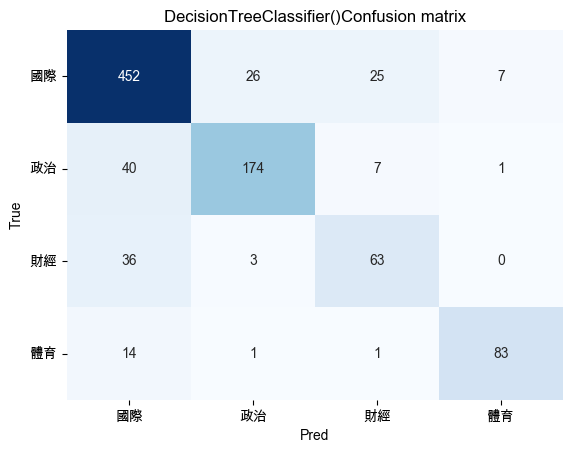

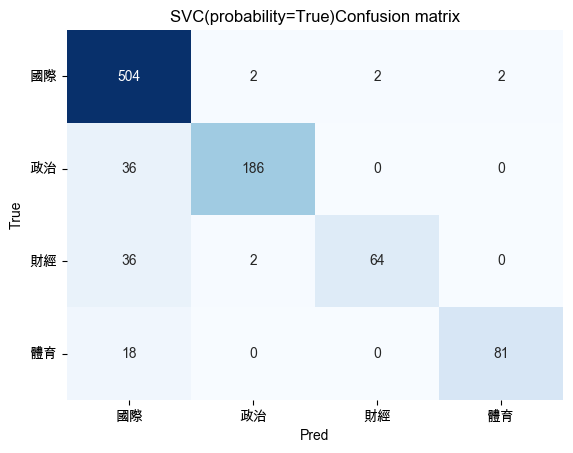

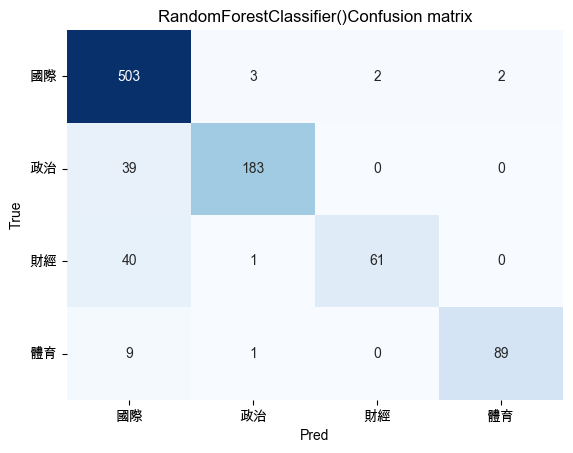

In [38]:
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
# vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)

In [39]:
result_set['clf_logistic']

{'國際': {'precision': 0.8444816053511706,
  'recall': 0.9901960784313726,
  'f1-score': 0.9115523465703972,
  'support': 510.0},
 '政治': {'precision': 0.9736842105263158,
  'recall': 0.8333333333333334,
  'f1-score': 0.8980582524271845,
  'support': 222.0},
 '財經': {'precision': 0.9692307692307692,
  'recall': 0.6176470588235294,
  'f1-score': 0.7544910179640718,
  'support': 102.0},
 '體育': {'precision': 0.975,
  'recall': 0.7878787878787878,
  'f1-score': 0.8715083798882681,
  'support': 99.0},
 'accuracy': 0.8906752411575563,
 'macro avg': {'precision': 0.940599146277064,
  'recall': 0.8072638146167559,
  'f1-score': 0.8589024992124803,
  'support': 933.0},
 'weighted avg': {'precision': 0.9027117384002974,
  'recall': 0.8906752411575563,
  'f1-score': 0.8869218030343101,
  'support': 933.0}}

In [40]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
print(result_set[best_model_name])

best model: clf_rf
{'國際': {'precision': 0.8510998307952623, 'recall': 0.9862745098039216, 'f1-score': 0.9137148047229792, 'support': 510.0}, '政治': {'precision': 0.973404255319149, 'recall': 0.8243243243243243, 'f1-score': 0.8926829268292683, 'support': 222.0}, '財經': {'precision': 0.9682539682539683, 'recall': 0.5980392156862745, 'f1-score': 0.7393939393939394, 'support': 102.0}, '體育': {'precision': 0.978021978021978, 'recall': 0.898989898989899, 'f1-score': 0.9368421052631579, 'support': 99.0}, 'accuracy': 0.8960342979635584, 'macro avg': {'precision': 0.9426950080975894, 'recall': 0.8269069872011048, 'f1-score': 0.8706584440523362, 'support': 933.0}, 'weighted avg': {'precision': 0.9064766762835108, 'recall': 0.8960342979635584, 'f1-score': 0.8921068707438922, 'support': 933.0}}


In [41]:
y_pred = model_set['clf_svm'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          國際       0.89      1.00      0.94       231
          政治       0.97      0.85      0.91        80
          財經       0.97      0.70      0.82        44
          體育       1.00      0.89      0.94        45

    accuracy                           0.92       400
   macro avg       0.96      0.86      0.90       400
weighted avg       0.93      0.92      0.92       400



In [42]:
model_set['clf_svm'].predict(vectorizer.transform(["俄國 異議 人士 納瓦尼 下葬 莫斯科 上萬 民眾 怒吼 普丁 殺人兇手"]).toarray())

array(['國際'], dtype=object)

### 5. 分析可解釋模型的結果

5.1 各字詞特徵的estimate係數

對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響

- coefficient estimate 代表特徵每增加一單位（在此處會是該文章的某字詞頻 +1），y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
- 這裡舉logistic regression + cv tokenizer 為例

In [43]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

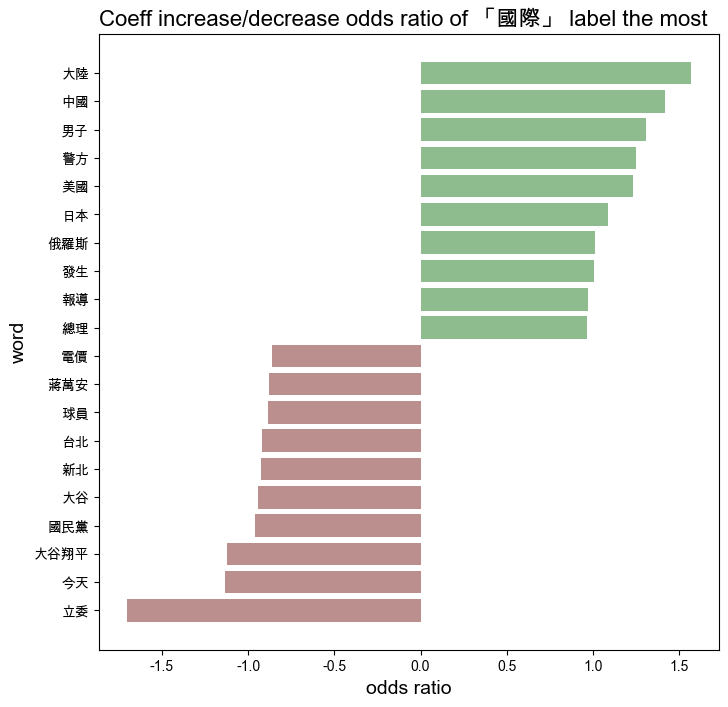

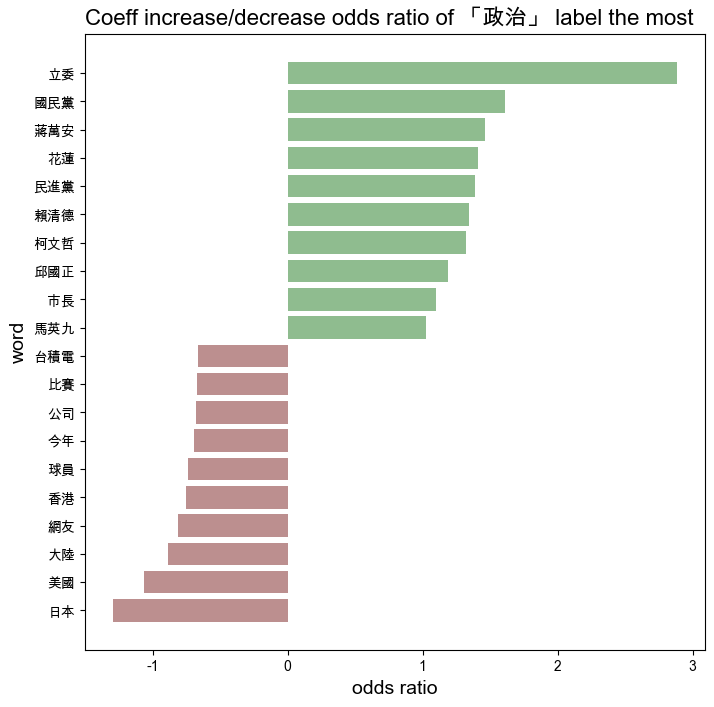

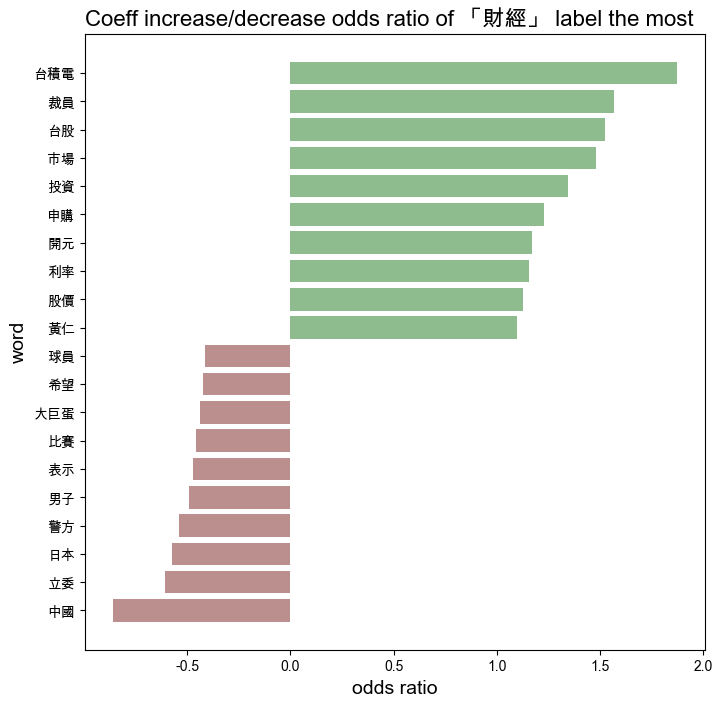

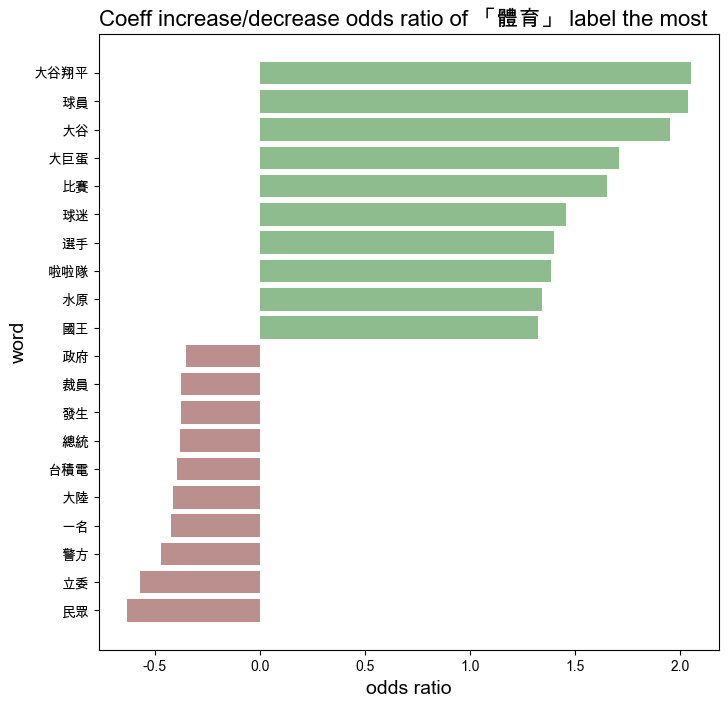

In [44]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

「財經」中出現了台積電、台股、投資等關鍵字；「國際」中高係數的字是美國、日本、大陸等國際新聞關鍵字；「政治」則是立委、蔣萬安、國民黨相關的字；「體育」出現了大谷翔平、球員、比賽相關字。

### 6. 預測新聞類別

udn_news.csv 為聯合新聞資料

- 版別：全球、股市、兩岸、運動
- 時間範圍：2024/03/01 ~ 2024/04/04
- 工作流程平台搜尋/排除關鍵字：無

In [85]:
udn = pd.read_csv("./raw_data/udn_news.csv")
udn.dropna(inplace=True)
udn

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,dataSource
0,1,MLB／曾說「不是朋友」成真 大谷翔平解除追蹤水原一平,2024/3/21 9:56,運動,https://udn.com/news/story/11247/7845714,曾經是形影不離的戰友，大谷翔平與水原一平如今因金錢關係成為陌生人，大谷翔平的個人社群也解除對...,UDN
1,2,MLB／水原一平涉賭被解僱 日本網友震驚「巨大背叛」,2024/3/21 10:28,運動,https://udn.com/news/story/11247/7845808,日本棒球明星大谷翔平的翻譯水原一平傳出涉嫌竊取數百萬美元非法簽賭，已遭洛杉磯道奇解雇。大谷轉...,UDN
2,3,MLB／偷大谷翔平的錢還賭債！水原一平IG被球迷灌爆：你搞屁啊,2024/3/21 10:36,運動,https://udn.com/news/story/11247/7845856,美國職棒大聯盟（MLB）球星大谷翔平的隨行翻譯水原一平，因涉嫌竊取大谷至少450萬美元進行非...,UDN
3,4,MLB／國內球評看水原一平醜聞 形容「比大谷結婚令人震撼」,2024/3/21 10:56,運動,https://udn.com/news/story/11247/7845919,道奇、教士隊在南韓首爾進行新球季第2場比賽前，大谷翔平的翻譯水原一平遭球團開除，一位美職賽事...,UDN
4,5,MLB／大谷翔平恐受牽連？水原一平稱他曾代為轉帳償還賭債後才改口,2024/3/21 12:13,運動,https://udn.com/news/story/11247/7846177,美國職棒大聯盟明星大谷翔平的翻譯水原一平傳出涉賭，遭球隊解僱。水原美國時間19日接受ESPN...,UDN
...,...,...,...,...,...,...,...
6453,6454,中獎慘劇！她中了3200萬大獎…彩票放口袋 家人「1動作」發財夢碎,2024/4/3 9:07,兩岸,https://udn.com/news/story/7335/7873960,數百萬獎金擦身而過！大陸有女子用10人民幣（約43元新台幣）買了張彩票，之後隨手將之放入口袋...,UDN
6454,6455,北大畢業人妻 擺攤賣手串月入21萬 「只是副業而已」,2024/4/3 20:30,兩岸,https://udn.com/news/story/7335/7875052,北大畢業、80後女孩月川靠著擺攤賣手串月入5萬元（人民幣，下同，約新台幣21萬元），引發網友...,UDN
6455,6456,初中畢鍋爐工 寫萬餘篇文章剖析「紅學」賺200萬,2024/4/3 14:22,兩岸,https://udn.com/news/story/7335/7875053,人生際遇難以預測，吉林省男子胡長遠，少年時因家逢變故、父親早死，輟學做苦力，僅有初中文憑的他...,UDN
6456,6457,裸女馬路大暴走片瘋傳！脫光衣服躺路中 驚揭心酸內情,2024/4/4 8:04,兩岸,https://udn.com/news/story/7335/7876986,全裸躺馬路中心，到底所為何事？大陸網絡近日瘋傳1段「裸女馬路暴走」影片，見到山西1條公路上，...,UDN


In [86]:
# 看看有幾篇文章
print(f"number of posts: {udn.shape[0]}")
print(f"date range: {(udn['artDate'].min(), udn['artDate'].max())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")

number of posts: 6458
date range: ('2024/3/17 0:38', '2024/4/4 9:46')
category: 
artCatagory
全球    2364
股市    1608
兩岸    1338
運動    1148
Name: count, dtype: int64


In [87]:
# 移除網址格式
udn["artContent"].str.replace("(http|https)://.*", "", regex=True)
udn["artTitle"].str.replace("(http|https)://.*", "", regex=True)
udn["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# 留下 content
udn["content"] = udn["artTitle"] +udn["artContent"]
udn = udn.loc[:,["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結


In [88]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [89]:
udn["words"] = udn["content"].apply(getToken).map(" ".join)
udn.head()

,content,artUrl,artCatagory,words
0,MLB／曾說「不是朋友」成真 大谷翔平解除追蹤水原一平曾經是形影不離的戰友，大谷翔平與水原一...,https://udn.com/news/story/11247/7845714,運動,MLB 朋友 成真 大谷翔平 解除 追蹤 水原 一平 曾經 形影不離 戰友 大谷翔平 水原 ...
1,MLB／水原一平涉賭被解僱 日本網友震驚「巨大背叛」日本棒球明星大谷翔平的翻譯水原一平傳出涉...,https://udn.com/news/story/11247/7845808,運動,MLB 水原 一平 涉賭 解僱 日本 網友 震驚 巨大 背叛 日本 棒球 明星 大谷翔平 翻...
2,MLB／偷大谷翔平的錢還賭債！水原一平IG被球迷灌爆：你搞屁啊美國職棒大聯盟（MLB）球星大...,https://udn.com/news/story/11247/7845856,運動,MLB 大谷翔平 錢還 賭債 水原 一平 IG 球迷 灌爆 美國 職棒 大聯盟 MLB 球星...
3,MLB／國內球評看水原一平醜聞 形容「比大谷結婚令人震撼」道奇、教士隊在南韓首爾進行新球季第...,https://udn.com/news/story/11247/7845919,運動,MLB 國內 球評 水原 一平 醜聞 形容 大谷 結婚 震撼 道奇 教士隊 南韓 首爾 進行...
4,MLB／大谷翔平恐受牽連？水原一平稱他曾代為轉帳償還賭債後才改口美國職棒大聯盟明星大谷翔平的...,https://udn.com/news/story/11247/7846177,運動,MLB 大谷翔平 恐受 牽連 水原 一平稱 代為 轉帳 償還 賭債 改口 美國 職棒 大聯盟...


In [90]:
udn['artCatagory'].value_counts()

artCatagory
全球    2364
股市    1608
兩岸    1338
運動    1148
Name: count, dtype: int64

In [91]:
mapper = {"股市":"財經","運動":"體育","兩岸": "政治", "全球":"國際"}
udn['artCatagory'] = udn['artCatagory'].map(mapper)

In [92]:
X =udn['words']
y =udn['artCatagory']

In [93]:
y_pred = model_set[best_model_name].predict(vectorizer.transform(X).toarray())
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          國際       0.54      0.87      0.66      2364
          政治       0.36      0.02      0.04      1338
          財經       0.80      0.76      0.78      1608
          體育       0.99      0.85      0.92      1148

    accuracy                           0.67      6458
   macro avg       0.67      0.63      0.60      6458
weighted avg       0.64      0.67      0.61      6458



In [96]:
udn['pred'] = y_pred
udn.loc[:,['words', 'artCatagory',"pred"]]

,words,artCatagory,pred
0,MLB 朋友 成真 大谷翔平 解除 追蹤 水原 一平 曾經 形影不離 戰友 大谷翔平 水原 ...,體育,體育
1,MLB 水原 一平 涉賭 解僱 日本 網友 震驚 巨大 背叛 日本 棒球 明星 大谷翔平 翻...,體育,體育
2,MLB 大谷翔平 錢還 賭債 水原 一平 IG 球迷 灌爆 美國 職棒 大聯盟 MLB 球星...,體育,體育
3,MLB 國內 球評 水原 一平 醜聞 形容 大谷 結婚 震撼 道奇 教士隊 南韓 首爾 進行...,體育,體育
4,MLB 大谷翔平 恐受 牽連 水原 一平稱 代為 轉帳 償還 賭債 改口 美國 職棒 大聯盟...,體育,體育
...,...,...,...
6453,中獎 慘劇 3200 萬大 彩票 口袋 家人 動作 發財 夢碎 數百 獎金 擦身而過 大陸 ...,政治,國際
6454,北大 畢業 人妻 攤賣 手串 月入 21 副業 北大 畢業 80 女孩 月川靠 攤賣 手串 ...,政治,國際
6455,初中 鍋爐 萬餘篇 文章 剖析 紅學 200 人生 際遇 難以 預測 吉林省 男子 長遠 少...,政治,國際
6456,裸女 馬路 暴走 瘋傳 脫光 衣服 心酸 內情 全裸 躺馬路 中心 大陸 網絡 近日 瘋傳 ...,政治,國際


In [97]:
false_pred = udn.query("artCatagory != pred").loc[:,['words', 'artCatagory',"pred"]]
false_pred

,words,artCatagory,pred
115,MLB 塞揚 強投 奈爾 報價 20 球團 猶豫 希望 降價 日前 The Athletic...,體育,國際
125,MLB 塞揚 拿不到 奈爾 落腳 巨人 今年 逃脫 球季 開打 兩屆 塞揚 投手 奈爾 Bl...,體育,國際
129,MLB 洋基 一喜 一優 賈吉將 回歸 但勒梅 修恐 趕不上 開季 紐約 洋基隊 今日 傷兵...,體育,國際
233,MLB 金鶯 伯恩斯 11K 楚奧特 陽春砲 寫近 57 首見 紀錄 金鶯 主場 開幕戰 1...,體育,國際
234,MLB 響尾蛇 單局 14 卡洛 沒刷 洛磯 投手 防禦率 162 響尾蛇隊 開幕戰 主場 ...,體育,國際
...,...,...,...
6453,中獎 慘劇 3200 萬大 彩票 口袋 家人 動作 發財 夢碎 數百 獎金 擦身而過 大陸 ...,政治,國際
6454,北大 畢業 人妻 攤賣 手串 月入 21 副業 北大 畢業 80 女孩 月川靠 攤賣 手串 ...,政治,國際
6455,初中 鍋爐 萬餘篇 文章 剖析 紅學 200 人生 際遇 難以 預測 吉林省 男子 長遠 少...,政治,國際
6456,裸女 馬路 暴走 瘋傳 脫光 衣服 心酸 內情 全裸 躺馬路 中心 大陸 網絡 近日 瘋傳 ...,政治,國際


In [101]:
false_pred.loc[false_pred['artCatagory']=='政治', :].head(50)

,words,artCatagory,pred
5120,拜習 通話 學者 中方 對美 經貿 限制 發出 尖銳 訊號 中國 國家 主席 習近平 美國 ...,政治,國際
5121,拜登 通話 習近平 關切 TikTok 所有權 美國 總統 拜登 中國 領導人 習近平 通話...,政治,國際
5122,拜習 通話 背後 意義 定調 階段 中美 關係 學者 關鍵 訊息 中國 國家 主席 習近平 ...,政治,國際
5123,拜登 習近平 通話 分析 中美 科技 限制 經濟 爭端 分歧 加深 大陸 國家 主席 習近平...,政治,國際
5124,外交部 習近平 拜登 強調 美不應 介入 中菲 南海 之爭 大陸 外交部 發言人 汪文斌 表...,政治,國際
5125,拜習 熱線 葉倫 宣布 啟程 訪陸 美國 總統 拜登 中國 大陸 國家 主席 習近平 二日 ...,政治,國際
5126,葉倫 到訪 陸盼 經濟 穩定 拜習 二日 通話 大陸 官媒 央視 新聞 隨即 三日 一早 宣...,政治,國際
5127,轉述 說法 南海 香港 主權 美勿 介入 大陸 外交部 發言人 汪文斌 昨天 表示 二日 習...,政治,國際
5128,觀察 拜習 默契 不求 突破 只求 穩定 拜登 習近平 通話 內容 凸顯 不求 突破 只求 ...,政治,國際
5130,兩岸 觀策 消費 降級 粉紅 愛國 降級 最近 中國 大陸 熱門 話題 台灣 電影 周處 三...,政治,國際


In [102]:
false_pred.loc[5121, :]

words          拜登 通話 習近平 關切 TikTok 所有權 美國 總統 拜登 中國 領導人 習近平 通話...
artCatagory                                                   政治
pred                                                          國際
Name: 5121, dtype: object

In [103]:
print(false_pred['words'][5121])

拜登 通話 習近平 關切 TikTok 所有權 美國 總統 拜登 中國 領導人 習近平 通話 關切 台海 問題 關注 TikTok 所有權 問題 習近平 明確 表示 這不 禁止 這款 應用 軟體 有意 剝離 能夠 保護 國家 安全 利益 美國 數據 安全 美國 之音 報導 TikTok 中國 影片 分享 平台 抖音 海外版 母公司 中國 字節 跳動 西方 官員 TikTok 年輕人 流行 表示 擔心 指稱 聽命 北京 宣傳 管道 字節 跳動 北京 否認 指稱 上個 美國 國會 眾議院 壓倒性 多數 一項 法案 迫使 TikTok 字節 跳動 剝離 面臨 全國 範圍 禁令 拜登 支持 這項 努力 競選 陣營 轉向 TikTok 爭取 年輕 選民 兩位 領導人 進行 議題 範圍 廣泛 電話 交談 之後 國家 安全 委員會 發言人 約翰 科比 John Kirby 總統 重申 TikTok 所有權 關切 拜登 競選 對手 川普 封禁 TikTok 表示 不安 通常 樂於 譴責 中國


從預測結果來看，「政治」這個版別常被預測為「國際」。從文章去看可以發現提到了「拜登」、「美國」、「中國 領導人 習近平」等等，這些關鍵詞彙可能造成預測錯誤的原因。這篇文章可能同時討論了兩岸關係和國際事務，使得模型難以區分這兩個類別！！